In [83]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
pd.set_option('display.max_rows',15)

In [84]:
# ---------------------- Load data ------------------------

In [85]:
# load bitcoin scaled data
bitcoin_scale = pd.read_csv ('/home/sunny/NWU/EECS349/Bitcoin_Price_Predictor/code/bitcoin_price_scaled.csv', \
                       parse_dates = True, index_col = [0])

In [86]:
# check data
bitcoin_scale

,Open,Close,Volume,Market Cap
0,-0.455745,-0.456843,-0.299032,-0.448995
1,-0.456037,-0.453352,-0.299032,-0.449183
2,-0.452796,-0.455224,-0.299032,-0.447038
3,-0.454491,-0.462664,-0.299032,-0.448144
4,-0.462159,-0.466646,-0.299032,-0.453187
5,-0.465594,-0.469168,-0.299032,-0.455443
6,-0.468357,-0.464182,-0.299032,-0.457257
...,...,...,...,...
1753,2.413988,2.707144,2.522310,2.438914
1754,2.715180,2.934215,2.934818,2.740778


In [87]:
# --------------------- Data preparation ---------------------

In [88]:
bitcoin_scale = np.array(bitcoin_scale)
# split data into training set and testing set
split = int(0.9 * bitcoin_scale.shape[0])
train_data = bitcoin_scale[0 : split]
test_data = bitcoin_scale[split : ]

In [89]:
bitcoin_scale

array([[-0.45574506, -0.45684347, -0.29903222, -0.44899489],
       [-0.45603663, -0.45335175, -0.29903222, -0.44918323],
       [-0.45279553, -0.45522437, -0.29903222, -0.44703786],
       ...,
       [ 3.26951589,  3.06448669,  2.82083002,  3.2969005 ],
       [ 3.07599936,  3.29214164,  2.43008002,  3.10357174],
       [ 3.3062664 ,  3.352444  ,  3.24400533,  3.33458834]])

In [90]:
# extract input and output training set
# input set: 1584 x 3 matrix
x_train = train_data[:, [0, 2, 3]]
# output set: 1584 x 1 matrix
y_train = train_data[:, 1]

# extract input and output testing set
# input set: 176 x 3 matrix
x_test = test_data[:, [0, 2, 3]]
# output set: 176 x 1 matrix
y_test = test_data[:, 1]

# check dataset
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1584, 3) (1584,) (176, 3) (176,)


In [91]:
# --------------------- Build neural network -------------------

In [92]:
# set number of datasets (columns)
n_dataset = x_train.shape[1]

# set number of neurons in each layer
n_neurons_1 = 4
n_neurons_2 = 2
n_target = 1

In [93]:
# session
net = tf.InteractiveSession()

/home/sunny/.conda/envs/py3env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [94]:
# define input and output placeholder for neural network
# The None argument indicates that at this point we do not yet know the number of 
# observations that flow through the neural net graph in each batch
X = tf.placeholder(dtype = tf.float32, name = "X", shape = [None, n_dataset])
Y = tf.placeholder(dtype = tf.float32, name = "Y", shape = [None])

In [95]:
# define initializer
sigma = 1.0
weight_initializer = tf.variance_scaling_initializer(mode = "fan_avg", distribution = "uniform", scale = sigma)
bias_initializer = tf.zeros_initializer()

In [96]:
# model architecture parameter
# hidden layers + bias

# Layer 1: Variables for hidden weights and biases
w_hidden_1 = tf.Variable(weight_initializer([n_dataset, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

# Layer 2: Variables for hidden weights and biases
w_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

# Output Layer:
w_out = tf.Variable(weight_initializer([n_neurons_2, n_target]))
bias_out = tf.Variable(bias_initializer([n_target]))

In [97]:
# activation function (ReLU) for each hidden layer

# activation function for hidden layer 1
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, w_hidden_1), bias_hidden_1))

# activation function for hidden layer 2
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, w_hidden_2), bias_hidden_2))

# output layer
out = tf.transpose(tf.add(tf.matmul(hidden_2, w_out), bias_out))

In [98]:
# define cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

In [99]:
# define optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

In [100]:
# initialize all variables above
net.run(tf.global_variables_initializer())

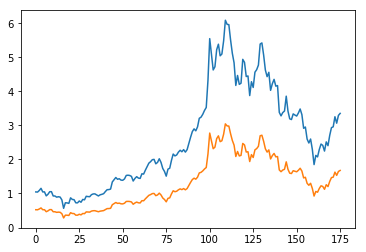

In [101]:
# set up plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test * 0.5)
plt.show()

In [102]:
# fit neural net
batch_size = 15
epochs = 10

mse_train = []
mse_test = []

for e in range(epochs):
    
    # shuffle the data first
    shuffle_indices = np.random.permutation(np.arange(0, len(y_train)))
    x_train = x_train[shuffle_indices]
    y_train = y_train[shuffle_indices]
    
    # mini-batch training
    for i in range(len(y_train) // batch_size):
        start = i * batch_size
        batch_x = x_train[start : start + batch_size]
        batch_y = y_train[start : start + batch_size]
        
        # run optimizer with batch
        net.run(opt, feed_dict = {X: batch_x, Y: batch_y})
        
        # show progress
        if np.mod(i , 50) == 0:
            
            # mse training and testing
            mse_train.append(net.run(mse, feed_dict = {X: batch_x, Y: batch_y}))
            mse_test.append(net.run(mse, feed_dict = {X: x_test, Y: y_test}))
        
        # prediction
        pred = net.run(out, feed_dict = {X: x_test})
        

The mean squared errors are [6.7347064, 6.41977, 5.992505, 5.9528413, 5.0909967, 4.1898394, 4.094931, 2.9509928, 2.0785866, 1.967978, 1.1802427, 0.61634207, 0.5653315, 0.28360605, 0.1289256, 0.12370649, 0.09429257, 0.085645586, 0.08550401, 0.086316004, 0.0906932, 0.09008848, 0.09452236, 0.08947671, 0.090180814, 0.09480134, 0.08947929, 0.090158135, 0.089477666, 0.09159731]


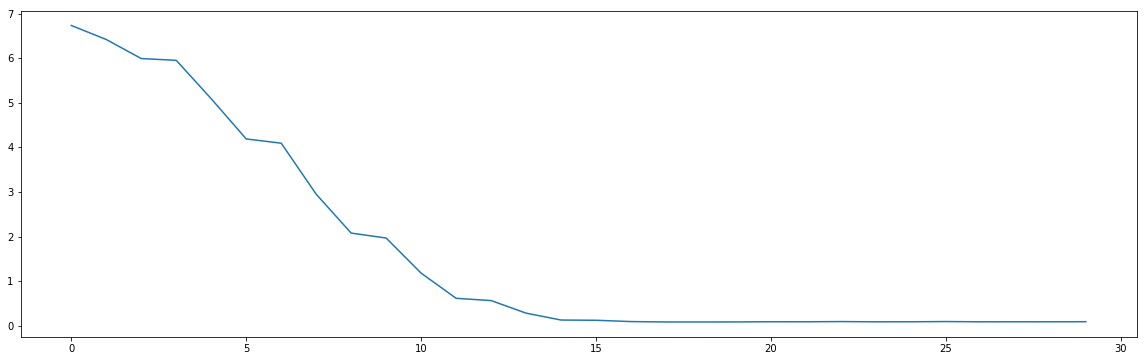

In [103]:
# plot learning curve
plt.figure(figsize = (20, 6))
plt.plot(mse_test)
plt.show

print("The mean squared errors are", str(mse_test))

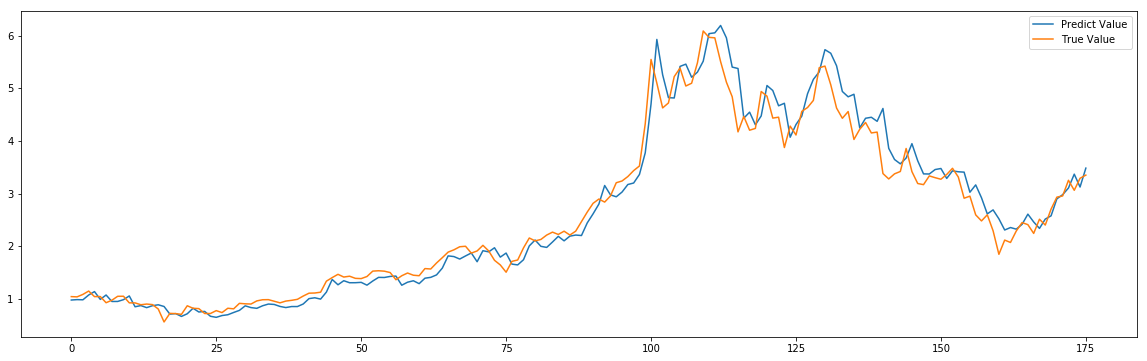

In [109]:
# plot the prediction values and true values
plt.figure(figsize = (20, 6))
plt.plot(pred[0], label = 'Predict Value')
plt.plot(y_test, label = 'True Value')
plt.legend(loc = 'best')
plt.show()

In [106]:
pred

array([[0.9808744 , 0.98862994, 0.98520684, 1.0763552 , 1.1412159 ,
        0.99283373, 1.0762666 , 0.95347357, 0.9539287 , 0.9874996 ,
        1.0583107 , 0.85281515, 0.8754475 , 0.8365284 , 0.87325   ,
        0.8906107 , 0.8581289 , 0.71360564, 0.72303593, 0.6695827 ,
        0.7199515 , 0.82437325, 0.75375605, 0.7649944 , 0.6725657 ,
        0.65252304, 0.6862823 , 0.7015238 , 0.74442077, 0.7844355 ,
        0.87080157, 0.83711755, 0.8233404 , 0.87198365, 0.90454376,
        0.89702296, 0.8591831 , 0.83792853, 0.85712624, 0.85706544,
        0.90538526, 1.0074626 , 1.0236686 , 0.9983895 , 1.131119  ,
        1.3710808 , 1.2703391 , 1.3476214 , 1.3090727 , 1.3097734 ,
        1.316369  , 1.2630363 , 1.3421199 , 1.4110302 , 1.4088871 ,
        1.428946  , 1.4353532 , 1.2618549 , 1.3192585 , 1.3464996 ,
        1.2917936 , 1.3951925 , 1.4113661 , 1.4579928 , 1.5872386 ,
        1.8190082 , 1.805909  , 1.7588452 , 1.8177158 , 1.8741063 ,
        1.7077657 , 1.9169279 , 1.8955404 , 1.97